In [205]:
#pip install pyspellchecker

In [206]:
 #nltk.download('stopwords')

In [207]:
import re
import string
import nltk
from nltk.corpus import stopwords

In [208]:
import pandas as pd
import requests

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [209]:
df = pd.read_csv('https://raw.githubusercontent.com/chefhaider/Fake-News-Detection-Kaggle/main/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/chefhaider/Fake-News-Detection-Kaggle/main/test.csv')

In [210]:
'print shape of data set: ',df.shape,test.shape

('print shape of data set: ', (7613, 5), (3263, 4))

In [211]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [212]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [213]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [214]:
df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

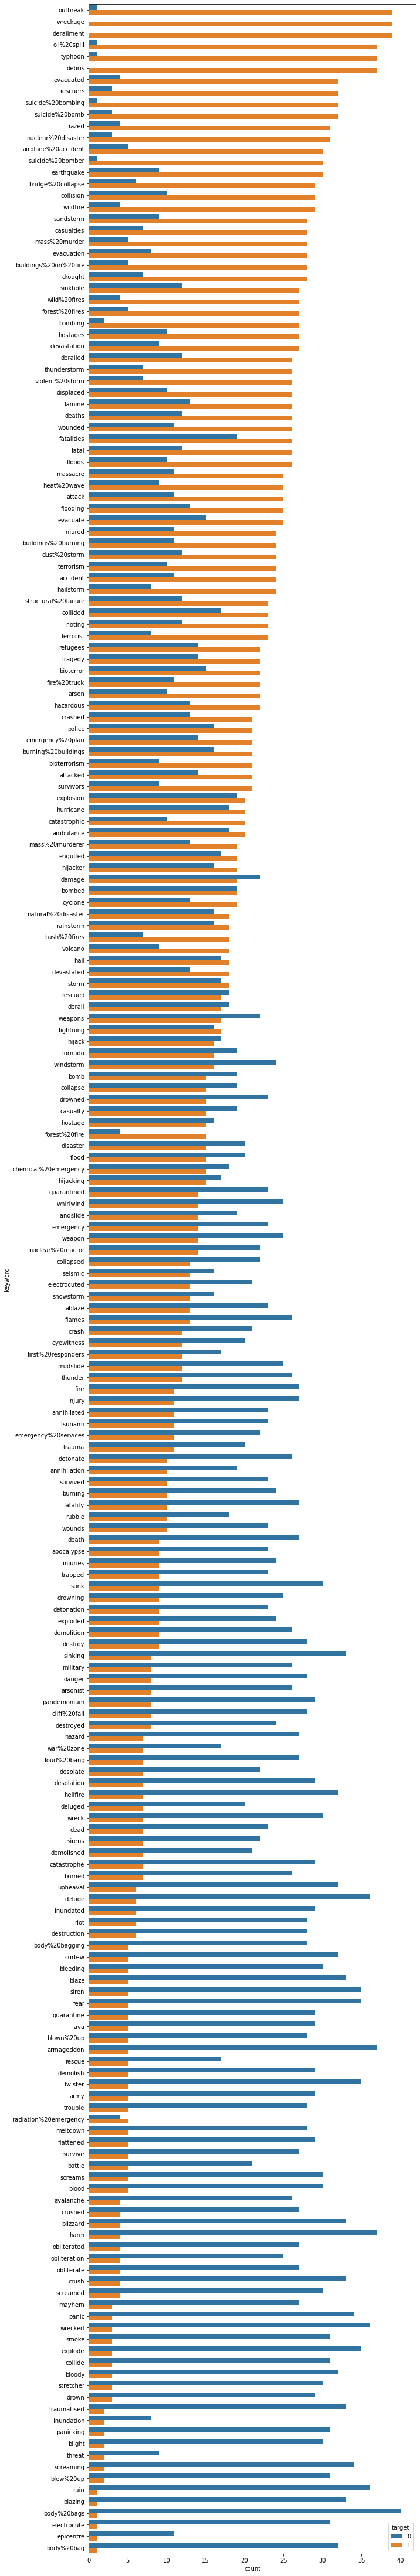

In [215]:
fig = plt.figure(figsize=(10,80))

sns.countplot(y="keyword",order=df[df.target == 1]['keyword'].value_counts().index, hue="target",data = df)

In [216]:
# cleaning geo locations

In [217]:
from spellchecker import SpellChecker
import re
import string


spell = SpellChecker()


def clean_text(text):


    url = re.compile(r'https?://\S+|www\.\S+')
    text = url.sub(r'',text)


    html=re.compile(r'<.*?>')
    text = html.sub(r'',text)



    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)


    table=str.maketrans('','',string.punctuation)
    return text.translate(table)



df['text'] = df['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

In [218]:
'''corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)'''

'corrected_text = []\n    misspelled_words = spell.unknown(text.split())\n    for word in text.split():\n        if word in misspelled_words:\n            corrected_text.append(spell.correction(word))\n        else:\n            corrected_text.append(word)\n    return " ".join(corrected_text)'

In [219]:
from sklearn.feature_extraction.text import TfidfVectorizer


tf_idf_vect = TfidfVectorizer(ngram_range=(1,3)) # one,two and three gram vectorization
tf_idf_mat = tf_idf_vect.fit_transform(df['text'].values) # fit_transform vectorizer to dtrain['text']
tf_idf_mat_test = tf_idf_vect.transform(test['text'].values) # fit_transform vectorizer to dtest['text']
type(tf_idf_mat)
print(tf_idf_mat.get_shape())

(7613, 149067)


In [220]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report





x, x_test, y, y_test = train_test_split(tf_idf_mat,df['target'],train_size=0.8, random_state = 0)

clf = MultinomialNB(alpha=1).fit(x, y)
pred = clf.predict(x_test)
 
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       0.75      0.95      0.84       886
           1       0.89      0.57      0.69       637

    accuracy                           0.79      1523
   macro avg       0.82      0.76      0.77      1523
weighted avg       0.81      0.79      0.78      1523

